# Deterministic Goldstein-Taylor equation
---
Consider the equation
$$
\left\{
\begin{aligned}
&\frac{\partial u}{\partial t} + \frac{\partial v}{\partial x} = 0, \\
&\frac{\partial v}{\partial t} + \frac{1}{\epsilon}\frac{\partial u}{\partial x} = - \frac{1}{\epsilon}v, 
\end{aligned}
\right.
$$
where $\epsilon$ is a small number.

The initial data are
$$
\left\{
\begin{aligned}
&u(x, 0) = 2, v(x, 0) = 0, x\in [-1, 0], \\
&u(x, 0) = 1, v(x, 0) = 0, x\in (0, 1],
\end{aligned}
\right.
$$

BC:
$$
u(-1, t) = 2, \ v(-1, t) = 0, \ u(1, t) = 1, \ v(1, t) = 0.
$$

The spatiotemporal domain is 
$$
(x, t) \in [-1, 1]\times [0, 0.02].
$$

---

## Mix Region:
$$
\epsilon(x) = \epsilon_0 + \frac{1}{2}\left(\tanh\left(1-\frac{11}{2}x\right) + \tanh\left(1+\frac{11}{2}x\right)\right).
$$

We set $\epsilon_0 = 10^{-12}$.

In [1]:
NAME = "4_mixed_region"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers
from jax.ops import index, index_add, index_update


import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *
from Seismic_wave_inversion_PINN.jax_model import *

from collections import namedtuple
# from jax.config import config; config.update("jax_enable_x64", True)
# dtype = jnp.float64
dtype = jnp.float32

In [3]:
key = random.PRNGKey(1)
key, subkey = random.split(key, 2)

layers = [2] + [32]*4 + [2] # (x, t) -> (u, v)
c0 = 1.0
w0 = jnp.array([[1.0, 1.0]]).T
w1 = jnp.array([[1.0, 1.0]]) # (w_u, w_v)
direct_params = init_siren_params(subkey, layers, c0, w0, w1, dtype)

domain = jnp.array([[-1., 0.], [1., 0.02]])
spatial_width = domain[1, 0]-domain[0, 0]

@jax.jit
def epsilon_fn(x):
	epsilon0 = 1e-12
	return epsilon0 + 0.5*(jnp.tanh(1-5.5*x) + jnp.tanh(1+5.5*x))

@jax.jit
def model(params, xt): # for predictions
	# linear scaling
	xt = (xt - domain[0, :])/(domain[1, :] - domain[0, :])
	for w, b in params[:-1]:
		xt = jnp.sin(jnp.dot(xt, w) + b)
	return jnp.dot(xt, params[-1][0]) + params[-1][1]

# @jax.jit
# def model_(params, xt): # for derivatives
# 	for w, b in params[:-1]:
# 		xt = jnp.sin(jnp.dot(xt, w) + b)
# 	return jnp.dot(xt, params[-1][0]) + params[-1][1]

jacobian = jacrev_fn(model)
hessian = hessian_fn(model)

In [4]:
metaloss = mae

# static_jit = lambda i: jax.partial(jax.jit, static_argnums = i)

# jacobian[i] = [[du/dx, du/dt],
#                [dv/dx, dv/dt]]
# i: the i^th input

# hessian[i] = [
#				[[du/dxx, du/dxy],
#                [du/dxy, du/dyy]],
#               [[dv/dxx, dv/dxy],
#                [dv/dxy, dv/dyy]]
#              ]
@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet = batch["collocation"], batch["dirichlet"]
	direct_params = params
	
	if collocation[0] is not None:
		epsilon_c = epsilon_fn(collocation.x)
		uv_c = model(direct_params, jnp.hstack([collocation.x, collocation.t]))
		u_c, v_c = uv_c[:, 0:1], uv_c[:, 1:2]
		duv_dxt_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t]))
		du_dt_c, dv_dt_c = duv_dxt_c[:, 0:1, 1], duv_dxt_c[:, 1:2, 1]
		du_dx_c, dv_dx_c = duv_dxt_c[:, 0:1, 0], duv_dxt_c[:, 1:2, 0]
		loss_c1 = metaloss(du_dt_c + dv_dx_c, 0)
		loss_c2 = metaloss(epsilon_c*dv_dt_c + du_dx_c, -v_c) # multiplied by epsilon_c
	else:
		loss_c1 = loss_c2 = 0
        
	if dirichlet[0] is not None:
		uv_d = model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t]))
		u_d, v_d = uv_d[:, 0:1], uv_d[:, 1:2]
		loss_d1 = metaloss(u_d, dirichlet.u)
		loss_d2 = metaloss(v_d, dirichlet.v)
		loss_d = loss_d1 + loss_d2
	else:
		loss_d = 0.0

	return loss_c1, loss_c2, loss_d

@jax.jit
def loss_fn(params, batch):
	w = batch["weights"]
	loss_c1, loss_c2, loss_d = loss_fn_(params, batch)
	return w["c1"]*loss_c1 + w["c2"]*loss_c2 + w["d"]*loss_d + l1_regularization(params, w["l1"]) + l2_regularization(params, w["l2"])

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	w = batch["weights"]
	loss_c1, loss_c2, loss_d = loss_fn_(params, batch)
	l1 = l1_regularization(params, 1.0)
	l2 = l2_regularization(params, 1.0)
	return w["c1"]*loss_c1 + w["c2"]*loss_c2 + w["d"]*loss_d, loss_c1, loss_c2, loss_d, l1, l2

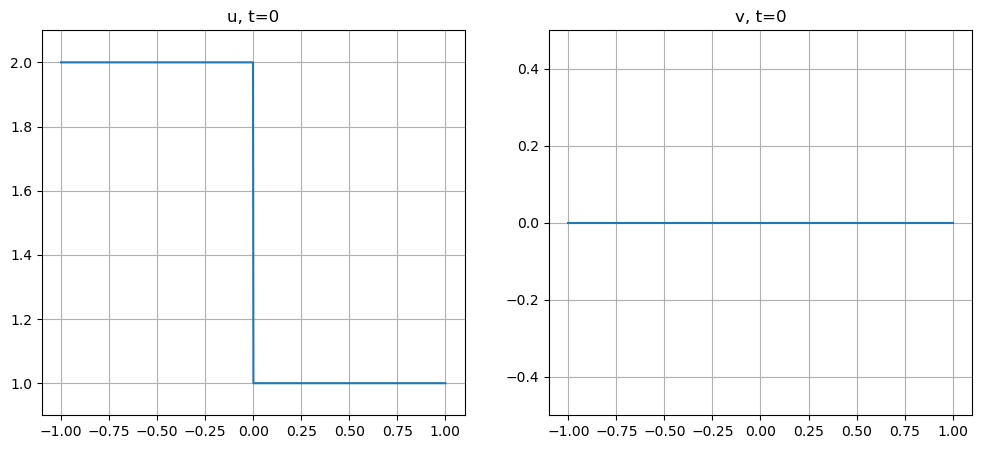

In [5]:
u0_fn = lambda x, t: jnp.select([x <= 0, x > 0], [2.0, 1.0])
v0_fn = lambda x, t: jnp.zeros_like(x)

u0_fn_ = lambda xt: jnp.select([xt[0] < 0, xt[0] > 0], [2.0, 1.0])
v0_fn_ = lambda xt: jnp.zeros_like(xt[0])

du0_dt_fn = lambda xt: jax.vmap(jax.jacfwd(u0_fn_), in_axes = 0)(xt)[:, 1:2]
dv0_dt_fn = lambda xt: jax.vmap(jax.jacfwd(v0_fn_), in_axes = 0)(xt)[:, 1:2]

du0_dx_fn = lambda xt: jax.vmap(jax.jacfwd(u0_fn_), in_axes = 0)(xt)[:, 0:1]
dv0_dx_fn = lambda xt: jax.vmap(jax.jacfwd(v0_fn_), in_axes = 0)(xt)[:, 0:1]

x0 = np.linspace(*domain[:, 0], 1000)
t0 = np.zeros_like(x0)
u0 = u0_fn(x0, t0)
v0 = v0_fn(x0, t0)

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

f, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(x0, u0)
ax[0].set_title("u, t=0")
ax[0].grid()
ax[0].set_ylim([0.9, 2.1])
ax[1].plot(x0, v0)
ax[1].set_title("v, t=0")
ax[1].grid()
ax[1].set_ylim([-0.5, 0.5])
plt.show()

key, *subkeys = random.split(key, 3)

n_i = 2000
x_i = jnp.linspace(*domain[:, 0], n_i).reshape((-1, 1))
t_i = jnp.zeros_like(x_i)
u_i = u0_fn(x_i, t_i)
v_i = v0_fn(x_i, t_i)

n_b = 2000
x_bl = jnp.ones((n_b, 1))*domain[0, 0]
x_br = jnp.ones((n_b, 1))*domain[1, 0]
t_b = jnp.linspace(*domain[:, 1], n_b).reshape((-1, 1))
x_b = jnp.vstack([x_bl, x_br])
t_b = jnp.vstack([t_b, t_b])
u_b = u0_fn(x_b, t_b)
v_b = v0_fn(x_b, t_b)

n_cx = 201
n_ct = 100
x_c = jnp.linspace(*domain[:, 0], n_cx).reshape((-1, 1))
t_c = jnp.linspace(*domain[:, 1], n_ct).reshape((-1, 1))
xt_c = tensor_grid([x_c, t_c])

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "t", "u", "v"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t"])

dirichlet = dataset_Dirichlet(jnp.vstack([x_i, x_b]), jnp.vstack([t_i, t_b]), jnp.vstack([u_i, u_b]), jnp.vstack([v_i, v_b]))
collocation = dataset_Collocation(xt_c[:, 0:1], xt_c[:, 1:2])

In [ ]:
# class Time_Marching_Generator:
# 	def __init__(self, key, spatial_points, temporal_domain, batch_size, iterations, update_every, count1 = 0):
# 		self.key = key
# 		self.spatial_points = spatial_points
# 		self.domain = temporal_domain
# 		self.batch_size = batch_size
# 		self.iterations = iterations
# 		self._count1 = count1
# 		self._count2 = update_every
# 		if count1 < iterations:
# 			self._update(self.domain[0])
# 		else:
# 			self._update(self.domain[1])
# 		self.update_every = update_every
		
# 	def _update(self, tmax):
# 		self.key, subkey = random.split(self.key)
# 		self._t = random.uniform(key, (self.batch_size, 1), jnp.float32, self.domain[0], tmax)
		
# 	def __iter__(self):
# 		return self
	
# 	def __next__(self):
# 		if self._count2 == self.update_every:
# 			self._count1 = max(self.iterations, self._count1 + 1)
# 			tmax = self.domain[0] + (self.domain[1]-self.domain[0])*self._count1/self.iterations
# 			self._update(tmax)
# 			self._count2 = 0
# 		else:
# 			self._count2 += 1
# 		return self.spatial_points, self._t

In [6]:
lr = 1e-3
params = direct_params
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
hist = {"iter": [], "loss": []}

batch_size = {"dirichlet": 4000, "collocation": 20100}
key, *subkeys = random.split(key, 5)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])

start_iteration = 0
iterations = 100000
print_every = 1000
save_every = 100000
weights = {"c1": 1.0, "c2": 10, "d": 10.0, "l1": 1e-8, "l2": 1e-8}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c1", "c2", "d", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"collocation": dataset_Collocation(*Collocation.dataset),
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/24, 13:53:20, Iteration: 0, Train Loss: 2.6308e+01, c1: 2.4555e+00, c2: 7.5589e-01, d: 1.6293e+00, l1_reg: 2.9865e+02, l2_reg: 4.4376e+01
2020/08/24, 13:53:31, Iteration: 1000, Train Loss: 4.4771e+00, c1: 1.0497e-01, c2: 3.5027e-01, d: 8.6943e-02, l1_reg: 3.0677e+02, l2_reg: 4.8363e+01
2020/08/24, 13:53:40, Iteration: 2000, Train Loss: 1.2355e+00, c1: 1.2234e-01, c2: 3.7246e-02, d: 7.4069e-02, l1_reg: 3.3009e+02, l2_reg: 6.1691e+01
2020/08/24, 13:53:48, Iteration: 3000, Train Loss: 4.6936e-01, c1: 1.0370e-01, c2: 9.9263e-03, d: 2.6640e-02, l1_reg: 3.3355e+02, l2_reg: 6.5134e+01
2020/08/24, 13:53:57, Iteration: 4000, Train Loss: 3.8967e-01, c1: 2.8811e-02, c2: 8.8111e-03, d: 2.7274e-02, l1_reg: 3.3450e+02, l2_reg: 6.6349e+01
2020/08/24, 13:54:05, Iteration: 5000, Train Loss: 3.4967e-01, c1: 1.9514e-02, c2: 6.3418e-03, d: 2.6674e-02, l1_reg: 3.3558e+02, l2_reg: 6.7412e+01
2020/08/24, 13:54:14, Iteration: 6000, Train Loss: 5.0240e-01, c1: 1.1261e-01, c2: 1.2787e-02, d: 2.6192e-02,

2020/08/24, 14:01:10, Iteration: 55000, Train Loss: 1.0853e-01, c1: 7.5998e-03, c2: 4.3167e-03, d: 5.7760e-03, l1_reg: 3.6306e+02, l2_reg: 1.0737e+02
2020/08/24, 14:01:18, Iteration: 56000, Train Loss: 1.0214e-01, c1: 7.6128e-03, c2: 2.5750e-03, d: 6.8780e-03, l1_reg: 3.6303e+02, l2_reg: 1.0801e+02
2020/08/24, 14:01:27, Iteration: 57000, Train Loss: 9.5071e-02, c1: 5.1054e-03, c2: 2.8931e-03, d: 6.1034e-03, l1_reg: 3.6292e+02, l2_reg: 1.0867e+02
2020/08/24, 14:01:35, Iteration: 58000, Train Loss: 1.2552e-01, c1: 6.9238e-03, c2: 5.7261e-03, d: 6.1332e-03, l1_reg: 3.6266e+02, l2_reg: 1.0931e+02
2020/08/24, 14:01:44, Iteration: 59000, Train Loss: 9.0464e-02, c1: 4.3216e-03, c2: 2.7825e-03, d: 5.8317e-03, l1_reg: 3.6264e+02, l2_reg: 1.1002e+02
2020/08/24, 14:01:53, Iteration: 60000, Train Loss: 9.8214e-02, c1: 5.8513e-03, c2: 2.7084e-03, d: 6.5279e-03, l1_reg: 3.6252e+02, l2_reg: 1.1073e+02
2020/08/24, 14:02:01, Iteration: 61000, Train Loss: 8.9435e-02, c1: 8.2240e-03, c2: 2.6953e-03, d: 5

In [10]:
start_iteration = 100000
iterations = 200000
print_every = 1000
save_every = 100000
weights = {"c1": 1.0, "c2": 10, "d": 10.0, "l1": 1e-8, "l2": 1e-8}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c1", "c2", "d", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"collocation": dataset_Collocation(*Collocation.dataset),
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/24, 14:24:38, Iteration: 100000, Train Loss: 6.8117e-02, c1: 6.5801e-03, c2: 2.3028e-03, d: 3.8509e-03, l1_reg: 3.5837e+02, l2_reg: 1.3529e+02
2020/08/24, 14:24:46, Iteration: 101000, Train Loss: 7.7239e-02, c1: 4.1343e-03, c2: 2.6099e-03, d: 4.7006e-03, l1_reg: 3.5852e+02, l2_reg: 1.3601e+02
2020/08/24, 14:24:55, Iteration: 102000, Train Loss: 5.7469e-02, c1: 3.1164e-03, c2: 1.7851e-03, d: 3.6502e-03, l1_reg: 3.5867e+02, l2_reg: 1.3677e+02
2020/08/24, 14:25:04, Iteration: 103000, Train Loss: 7.0903e-02, c1: 6.1055e-03, c2: 1.8790e-03, d: 4.6007e-03, l1_reg: 3.5863e+02, l2_reg: 1.3747e+02
2020/08/24, 14:25:12, Iteration: 104000, Train Loss: 8.3924e-02, c1: 8.3400e-03, c2: 3.1944e-03, d: 4.3640e-03, l1_reg: 3.5879e+02, l2_reg: 1.3827e+02
2020/08/24, 14:25:20, Iteration: 105000, Train Loss: 7.1899e-02, c1: 5.0665e-03, c2: 2.0782e-03, d: 4.6050e-03, l1_reg: 3.5872e+02, l2_reg: 1.3904e+02
2020/08/24, 14:25:29, Iteration: 106000, Train Loss: 6.8652e-02, c1: 3.5923e-03, c2: 2.6481e-0

2020/08/24, 14:32:24, Iteration: 155000, Train Loss: 7.4680e-02, c1: 3.5658e-03, c2: 3.3261e-03, d: 3.7854e-03, l1_reg: 3.6431e+02, l2_reg: 1.7920e+02
2020/08/24, 14:32:33, Iteration: 156000, Train Loss: 6.5245e-02, c1: 5.0653e-03, c2: 2.6288e-03, d: 3.3892e-03, l1_reg: 3.6474e+02, l2_reg: 1.7993e+02
2020/08/24, 14:32:41, Iteration: 157000, Train Loss: 7.4411e-02, c1: 3.6069e-03, c2: 3.3313e-03, d: 3.7491e-03, l1_reg: 3.6525e+02, l2_reg: 1.8107e+02
2020/08/24, 14:32:50, Iteration: 158000, Train Loss: 6.0007e-02, c1: 3.3387e-03, c2: 1.5922e-03, d: 4.0746e-03, l1_reg: 3.6507e+02, l2_reg: 1.8186e+02
2020/08/24, 14:32:58, Iteration: 159000, Train Loss: 7.1731e-02, c1: 5.7704e-03, c2: 2.8698e-03, d: 3.7263e-03, l1_reg: 3.6514e+02, l2_reg: 1.8283e+02
2020/08/24, 14:33:07, Iteration: 160000, Train Loss: 5.7854e-02, c1: 5.8377e-03, c2: 2.0078e-03, d: 3.1938e-03, l1_reg: 3.6531e+02, l2_reg: 1.8355e+02
2020/08/24, 14:33:15, Iteration: 161000, Train Loss: 6.6727e-02, c1: 5.0080e-03, c2: 2.9371e-0

2020/08/24, 14:40:10, Iteration: 210000, Train Loss: 9.1896e-02, c1: 8.4330e-03, c2: 5.1540e-03, d: 3.1923e-03, l1_reg: 3.5960e+02, l2_reg: 2.1308e+02
2020/08/24, 14:40:19, Iteration: 211000, Train Loss: 6.4134e-02, c1: 3.7754e-03, c2: 3.1558e-03, d: 2.8801e-03, l1_reg: 3.5837e+02, l2_reg: 2.1341e+02
2020/08/24, 14:40:27, Iteration: 212000, Train Loss: 6.7331e-02, c1: 2.1933e-03, c2: 2.4147e-03, d: 4.0991e-03, l1_reg: 3.5855e+02, l2_reg: 2.1380e+02
2020/08/24, 14:40:36, Iteration: 213000, Train Loss: 5.5867e-02, c1: 3.3221e-03, c2: 2.0406e-03, d: 3.2138e-03, l1_reg: 3.5792e+02, l2_reg: 2.1425e+02
2020/08/24, 14:40:44, Iteration: 214000, Train Loss: 6.5901e-02, c1: 3.2666e-03, c2: 2.1786e-03, d: 4.0848e-03, l1_reg: 3.5820e+02, l2_reg: 2.1486e+02
2020/08/24, 14:40:53, Iteration: 215000, Train Loss: 6.5985e-02, c1: 3.0873e-03, c2: 3.7924e-03, d: 2.4973e-03, l1_reg: 3.5835e+02, l2_reg: 2.1544e+02
2020/08/24, 14:41:01, Iteration: 216000, Train Loss: 4.8500e-02, c1: 2.6204e-03, c2: 1.6302e-0

2020/08/24, 14:47:55, Iteration: 265000, Train Loss: 8.5034e-02, c1: 6.5336e-03, c2: 5.0862e-03, d: 2.7639e-03, l1_reg: 3.5602e+02, l2_reg: 2.3953e+02
2020/08/24, 14:48:03, Iteration: 266000, Train Loss: 5.4137e-02, c1: 2.3580e-03, c2: 2.5072e-03, d: 2.6707e-03, l1_reg: 3.5733e+02, l2_reg: 2.3999e+02
2020/08/24, 14:48:12, Iteration: 267000, Train Loss: 4.5384e-02, c1: 2.7318e-03, c2: 2.0556e-03, d: 2.2097e-03, l1_reg: 3.5660e+02, l2_reg: 2.4047e+02
2020/08/24, 14:48:20, Iteration: 268000, Train Loss: 3.7070e-02, c1: 2.2532e-03, c2: 1.1698e-03, d: 2.3119e-03, l1_reg: 3.5624e+02, l2_reg: 2.4104e+02
2020/08/24, 14:48:29, Iteration: 269000, Train Loss: 6.4827e-02, c1: 2.1923e-03, c2: 2.9175e-03, d: 3.3459e-03, l1_reg: 3.5730e+02, l2_reg: 2.4152e+02
2020/08/24, 14:48:37, Iteration: 270000, Train Loss: 5.4551e-02, c1: 2.2250e-03, c2: 1.6086e-03, d: 3.6240e-03, l1_reg: 3.5675e+02, l2_reg: 2.4204e+02
2020/08/24, 14:48:45, Iteration: 271000, Train Loss: 6.3131e-02, c1: 2.3350e-03, c2: 1.5187e-0

In [14]:
# start_iteration = 300000
# iterations = 200000
# print_every = 1000
# save_every = 100000
# weights = {"c1": 1.0, "c2": 10, "d": 10.0, "l1": 1e-8, "l2": 1e-8}

# for iteration in range(start_iteration, start_iteration+iterations+1):
# 	d = next(Dirichlet)
# 	c = next(Collocation)
# 	batch = {
# 		"dirichlet": dataset_Dirichlet(*d),
# 		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
# 		"weights": weights,
# 	}
# 	opt_state = step(iteration, opt_state, batch)
# 	if (iteration-start_iteration) % print_every == 0:
# 		names = ["Loss", "c1", "c2", "d", "l1_reg", "l2_reg"]
# 		params_ = get_params(opt_state)
# 		batch = {
# 			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
# 			"collocation": dataset_Collocation(*Collocation.dataset),
# 			"weights": weights
# 		}
# 		losses = evaluate(params_, batch)
# 		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
# 			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
# 		hist["iter"].append(iteration)
# 		hist["loss"].append(losses)
# 	if (iteration-start_iteration) % save_every == 0:
# 		params_ = np.asarray(get_params(opt_state), dtype = object)
# 		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
# 		if not os.path.exists(os.path.dirname(save_path)):
# 			os.makedirs(os.path.dirname(save_path))
# 		np.save(save_path, params_)

2020/08/24, 16:28:36, Iteration: 300000, Train Loss: 6.1771e-02, c1: 1.4912e-03, c2: 2.5727e-03, d: 3.4553e-03, l1_reg: 3.5754e+02, l2_reg: 2.5371e+02
2020/08/24, 16:28:45, Iteration: 301000, Train Loss: 4.2624e-02, c1: 1.8296e-03, c2: 1.6595e-03, d: 2.4200e-03, l1_reg: 3.5731e+02, l2_reg: 2.5398e+02
2020/08/24, 16:28:54, Iteration: 302000, Train Loss: 4.7779e-02, c1: 1.6269e-03, c2: 1.4252e-03, d: 3.1901e-03, l1_reg: 3.5550e+02, l2_reg: 2.5438e+02
2020/08/24, 16:29:02, Iteration: 303000, Train Loss: 5.2697e-02, c1: 3.2569e-03, c2: 2.6304e-03, d: 2.3137e-03, l1_reg: 3.5544e+02, l2_reg: 2.5471e+02
2020/08/24, 16:29:11, Iteration: 304000, Train Loss: 5.6622e-02, c1: 2.1390e-03, c2: 2.0928e-03, d: 3.3556e-03, l1_reg: 3.5548e+02, l2_reg: 2.5506e+02
2020/08/24, 16:29:19, Iteration: 305000, Train Loss: 4.5127e-02, c1: 2.0510e-03, c2: 1.5105e-03, d: 2.7971e-03, l1_reg: 3.5516e+02, l2_reg: 2.5537e+02
2020/08/24, 16:29:28, Iteration: 306000, Train Loss: 3.7503e-02, c1: 1.4601e-03, c2: 1.3194e-0

2020/08/24, 16:36:24, Iteration: 355000, Train Loss: 6.0468e-02, c1: 2.3746e-03, c2: 2.0702e-03, d: 3.7392e-03, l1_reg: 3.5790e+02, l2_reg: 2.7843e+02
2020/08/24, 16:36:32, Iteration: 356000, Train Loss: 4.0292e-02, c1: 1.5584e-03, c2: 1.3477e-03, d: 2.5257e-03, l1_reg: 3.5861e+02, l2_reg: 2.7885e+02
2020/08/24, 16:36:40, Iteration: 357000, Train Loss: 4.3253e-02, c1: 1.9323e-03, c2: 1.4326e-03, d: 2.6995e-03, l1_reg: 3.5807e+02, l2_reg: 2.7945e+02
2020/08/24, 16:36:49, Iteration: 358000, Train Loss: 4.1600e-02, c1: 3.4713e-03, c2: 1.6129e-03, d: 2.1999e-03, l1_reg: 3.6033e+02, l2_reg: 2.7991e+02
2020/08/24, 16:36:58, Iteration: 359000, Train Loss: 4.8056e-02, c1: 1.8203e-03, c2: 1.3649e-03, d: 3.2587e-03, l1_reg: 3.5915e+02, l2_reg: 2.8048e+02
2020/08/24, 16:37:06, Iteration: 360000, Train Loss: 4.6869e-02, c1: 1.6612e-03, c2: 1.7803e-03, d: 2.7405e-03, l1_reg: 3.5898e+02, l2_reg: 2.8088e+02
2020/08/24, 16:37:14, Iteration: 361000, Train Loss: 5.0900e-02, c1: 2.2168e-03, c2: 2.8178e-0

2020/08/24, 16:44:07, Iteration: 410000, Train Loss: 5.1569e-02, c1: 4.1688e-03, c2: 2.0008e-03, d: 2.7393e-03, l1_reg: 3.6858e+02, l2_reg: 3.0383e+02
2020/08/24, 16:44:16, Iteration: 411000, Train Loss: 6.0670e-02, c1: 2.0639e-03, c2: 3.0855e-03, d: 2.7751e-03, l1_reg: 3.6694e+02, l2_reg: 3.0427e+02
2020/08/24, 16:44:25, Iteration: 412000, Train Loss: 4.9159e-02, c1: 2.9370e-03, c2: 2.1418e-03, d: 2.4805e-03, l1_reg: 3.6656e+02, l2_reg: 3.0482e+02
2020/08/24, 16:44:33, Iteration: 413000, Train Loss: 4.7380e-02, c1: 2.5645e-03, c2: 2.0351e-03, d: 2.4464e-03, l1_reg: 3.6888e+02, l2_reg: 3.0527e+02
2020/08/24, 16:44:41, Iteration: 414000, Train Loss: 5.0914e-02, c1: 2.3318e-03, c2: 1.7464e-03, d: 3.1118e-03, l1_reg: 3.6763e+02, l2_reg: 3.0568e+02
2020/08/24, 16:44:50, Iteration: 415000, Train Loss: 6.8569e-02, c1: 2.9873e-03, c2: 3.4980e-03, d: 3.0602e-03, l1_reg: 3.6715e+02, l2_reg: 3.0621e+02
2020/08/24, 16:44:58, Iteration: 416000, Train Loss: 5.1905e-02, c1: 2.2519e-03, c2: 2.0754e-0

2020/08/24, 16:51:53, Iteration: 465000, Train Loss: 4.4734e-02, c1: 1.7733e-03, c2: 1.9035e-03, d: 2.3926e-03, l1_reg: 3.7547e+02, l2_reg: 3.2822e+02
2020/08/24, 16:52:01, Iteration: 466000, Train Loss: 5.9019e-02, c1: 4.6174e-03, c2: 2.4997e-03, d: 2.9404e-03, l1_reg: 3.7366e+02, l2_reg: 3.2848e+02
2020/08/24, 16:52:10, Iteration: 467000, Train Loss: 3.6561e-02, c1: 1.3923e-03, c2: 1.1455e-03, d: 2.3714e-03, l1_reg: 3.7558e+02, l2_reg: 3.2896e+02
2020/08/24, 16:52:18, Iteration: 468000, Train Loss: 5.9112e-02, c1: 1.8313e-03, c2: 3.4441e-03, d: 2.2840e-03, l1_reg: 3.7432e+02, l2_reg: 3.2939e+02
2020/08/24, 16:52:27, Iteration: 469000, Train Loss: 4.6350e-02, c1: 1.8614e-03, c2: 1.7327e-03, d: 2.7161e-03, l1_reg: 3.7454e+02, l2_reg: 3.2982e+02
2020/08/24, 16:52:35, Iteration: 470000, Train Loss: 4.0352e-02, c1: 1.8895e-03, c2: 1.7558e-03, d: 2.0904e-03, l1_reg: 3.7471e+02, l2_reg: 3.3023e+02
2020/08/24, 16:52:44, Iteration: 471000, Train Loss: 4.8671e-02, c1: 3.1911e-03, c2: 1.5441e-0

In [15]:
params_ = get_params(opt_state)

x_test = jnp.linspace(*domain[:, 0], 200)
t_test = jnp.linspace(*domain[:, 1], 200)
xt_tests = [tensor_grid([x_test, ti]) for ti in t_test]
uv_preds = [model(params_, xt_test) for xt_test in xt_tests]
u_preds, v_preds = [uv_pred[:, 0:1] for uv_pred in uv_preds], [uv_pred[:, 1:2] for uv_pred in uv_preds]
duv_dxt_preds = [jacobian(params_, xt_test) for xt_test in xt_tests]
du_dx_preds, dv_dx_preds = [duv_dxt_pred[:, 0:1, 0] for duv_dxt_pred in duv_dxt_preds], [duv_dxt_pred[:, 1:2, 0] for duv_dxt_pred in duv_dxt_preds]
du_dt_preds, dv_dt_preds = [duv_dxt_pred[:, 0:1, 1] for duv_dxt_pred in duv_dxt_preds], [duv_dxt_pred[:, 1:2, 1] for duv_dxt_pred in duv_dxt_preds]

<IPython.core.display.Javascript object>


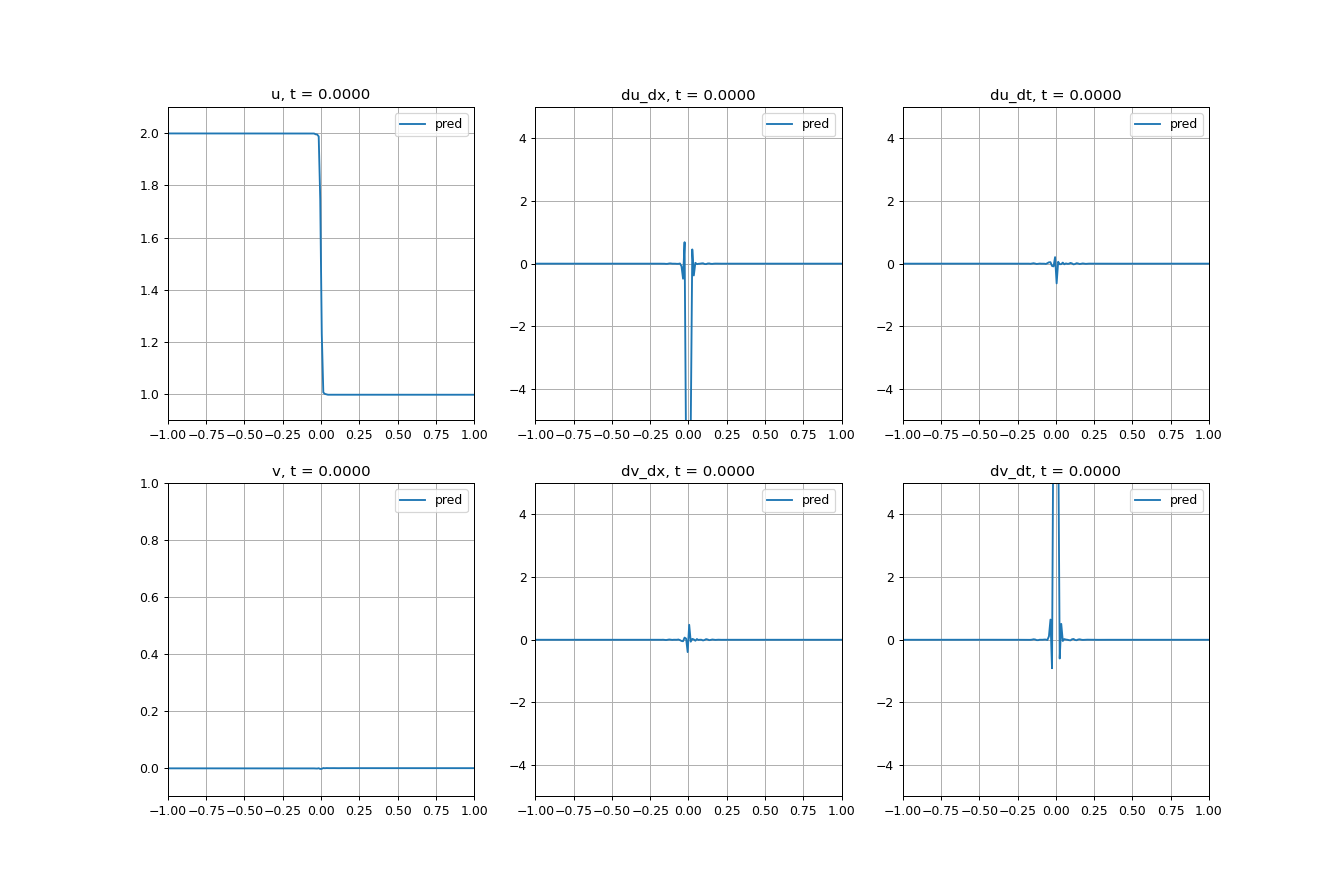

In [16]:
from matplotlib import animation
%matplotlib notebook

fig, ax = plt.subplots(2, 3, figsize = (15, 10))
lines = []
for i in range(2):
	for j in range(3):
		line, = ax[i][j].plot([], [], lw = 1.5, label = "pred")
		lines.append(line)
		ax[i][j].set_xlim([-1, 1])
		ax[i][j].set_ylim([-5, 5])
		ax[i][j].legend()
		ax[i][j].grid()
ax[0][0].set_ylim([0.9, 2.1])
ax[1][0].set_ylim([-0.1, 1.0])
    
def init():
	for line in lines:
		line.set_data([], [])
	return lines

def animate(i):
	u_pred, v_pred = u_preds[i], v_preds[i]
	du_dx_pred, dv_dx_pred = du_dx_preds[i], dv_dx_preds[i]
	du_dt_pred, dv_dt_pred = du_dt_preds[i], dv_dt_preds[i]
# 	u_true, v_true = np.real(uv_true[i, :]), np.imag(uv_true[i, :])
	
	lines[0].set_data(x_test, u_pred)
	ax[0][0].set_title("u, t = {:.4f}".format(t_test[i]))
	lines[1].set_data(x_test, du_dx_pred)
	ax[0][1].set_title("du_dx, t = {:.4f}".format(t_test[i]))
	lines[2].set_data(x_test, du_dt_pred)
	ax[0][2].set_title("du_dt, t = {:.4f}".format(t_test[i]))
    
	lines[3].set_data(x_test, v_pred)
	ax[1][0].set_title("v, t = {:.4f}".format(t_test[i]))
	lines[4].set_data(x_test, dv_dx_pred)
	ax[1][1].set_title("dv_dx, t = {:.4f}".format(t_test[i]))
	lines[5].set_data(x_test, dv_dt_pred)
	ax[1][2].set_title("dv_dt, t = {:.4f}".format(t_test[i]))

	return lines

anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 50, blit = True)
plt.show()

<IPython.core.display.Javascript object>


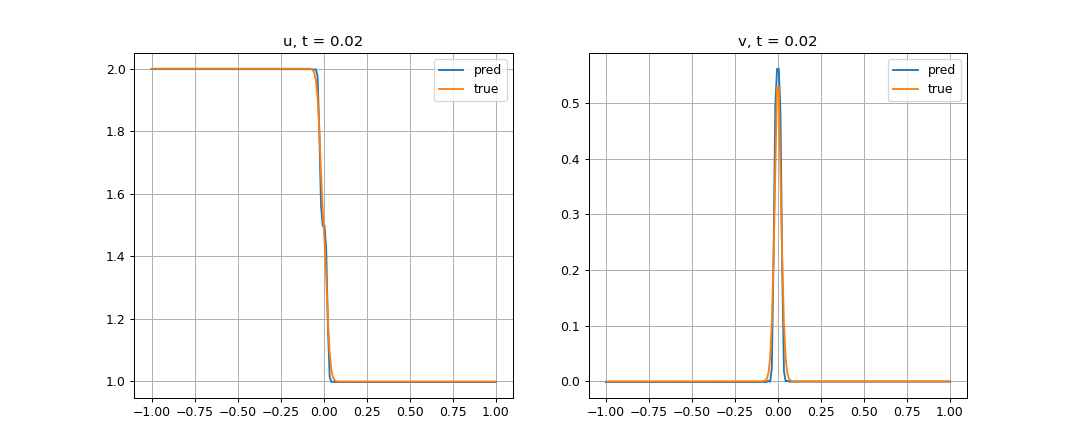

In [21]:
from scipy.io import loadmat
data = loadmat("mixed_region.mat")
x_true, u_true, v_true = data["x"], data["u"], data["v"]

f, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(x_test, u_preds[-1], label = "pred")
ax[0].plot(x_true, u_true, label = "true")
ax[0].set_title("u, t = {:.2f}".format(t_test[-1]))
ax[1].plot(x_test, v_preds[-1], label = "pred")
ax[1].plot(x_true, v_true, label = "true")
ax[1].set_title("v, t = {:.2f}".format(t_test[-1]))
for i in range(2):
	ax[i].legend()
	ax[i].grid()
plt.show()

<IPython.core.display.Javascript object>


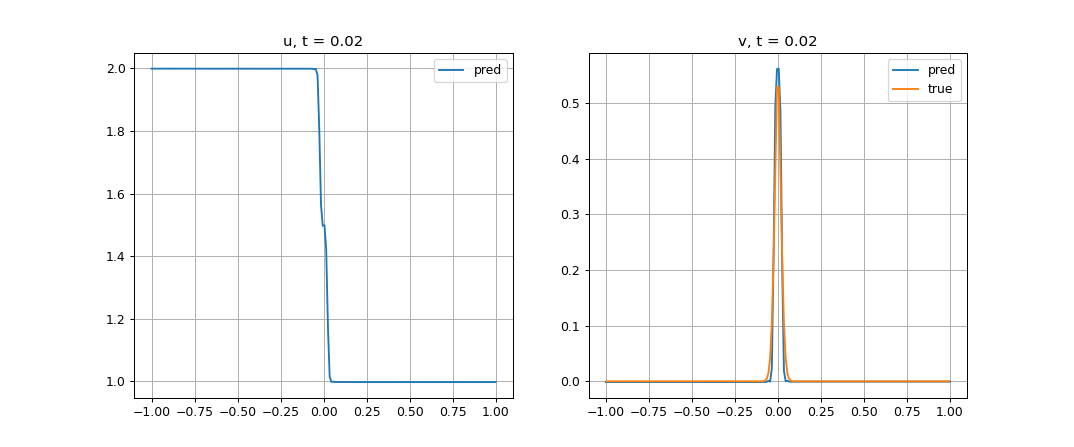

In [22]:
from scipy.io import loadmat
data = loadmat("mixed_region.mat")
x_true, u_true, v_true = data["x"], data["u"], data["v"]

f, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(x_test, u_preds[-1], label = "pred")
# ax[0].plot(x_true, u_true, label = "true")
ax[0].set_title("u, t = {:.2f}".format(t_test[-1]))
ax[1].plot(x_test, v_preds[-1], label = "pred")
ax[1].plot(x_true, v_true, label = "true")
ax[1].set_title("v, t = {:.2f}".format(t_test[-1]))
for i in range(2):
	ax[i].legend()
	ax[i].grid()
plt.show()

In [ ]:
# x = jnp.linspace(*domain[:, 0], 10000).reshape((-1, 1))
# t = jnp.zeros_like(x)
# xt = jnp.hstack([x, t])


# # direct_params_ = direct_params
# direct_params_ = get_params(opt_state)
# duv_dxt = jacobian(direct_params_, xt)
# du_dt, dv_dt = duv_dxt[:, 0:1, 1], duv_dxt[:, 1:2, 1]
# du_dx, dv_dx = duv_dxt[:, 0:1, 0], duv_dxt[:, 1:2, 0]
# duv_dxxtt = hessian(direct_params_, xt)
# du_dxx, dv_dxx = duv_dxxtt[:, 0:1, 0, 0], duv_dxxtt[:, 1:2, 0, 0] 
# uv = model(direct_params_, xt)
# u, v = uv[:, 0:1], uv[:, 1:2]
# loss_c1 = epsilon*du_dt + 0.5*epsilon**2*dv_dxx - V*v
# loss_c2 = epsilon*dv_dt - 0.5*epsilon**2*du_dxx + V*u

# du0_dx, dv0_dx = du0_dx_fn(xt), dv0_dx_fn(xt)
# du0_dxx, dv0_dxx = du0_dxx_fn(xt), dv0_dxx_fn(xt)
# u0, v0 = u0_fn(xt[:, 0:1], xt[:, 1:2]), v0_fn(xt[:, 0:1], xt[:, 1:2])
# du0_dt = 1.0/epsilon*(V*v0 - epsilon**2/2*dv0_dxx)
# dv0_dt = 1.0/epsilon*(epsilon**2/2*du0_dxx - V*u0)
# loss_c10 = epsilon*du0_dt + 0.5*epsilon**2*dv0_dxx - V*v0
# loss_c20 = epsilon*dv0_dt - 0.5*epsilon**2*du0_dxx + V*u0

# %matplotlib inline
# plt.rcParams.update(plt.rcParamsDefault)
# plt.rcParams["text.usetex"] = True

# f, ax = plt.subplots(2, 5, figsize = (20, 10))
# i, j = 0, 0
# ax[i][j].plot(x, du_dt, label = "pred")
# ax[i][j].plot(x, du0_dt, label = "true")
# ax[i][j].set_title(r"$\frac{\partial u}{\partial t}$")
# i = 1
# ax[i][j].plot(x, dv_dt, label = "pred")
# ax[i][j].plot(x, dv0_dt, label = "true")
# ax[i][j].set_title(r"$\frac{\partial v}{\partial t}$")
# i, j = 0, j+1
# ax[i][j].plot(x, du_dx, label = "pred")
# ax[i][j].plot(x, du0_dx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial u}{\partial x}$")
# i = 1
# ax[i][j].plot(x, dv_dx, label = "pred")
# ax[i][j].plot(x, dv0_dx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial v}{\partial x}$")
# i, j = 0, j+1
# ax[i][j].plot(x, du_dxx, label = "pred")
# ax[i][j].plot(x, du0_dxx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial^2 u}{\partial x^2}$")
# i = 1
# ax[i][j].plot(x, dv_dxx, label = "pred")
# ax[i][j].plot(x, dv0_dxx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial^2 v}{\partial x^2}$")
# i, j = 0, j+1
# ax[i][j].plot(x, u, label = "pred")
# ax[i][j].plot(x, u0, label = "true")
# ax[i][j].set_title(r"$u$")
# i = 1
# ax[i][j].plot(x, v, label = "pred")
# ax[i][j].plot(x, v0, label = "true")
# ax[i][j].set_title(r"$v$")
# i, j = 0, j+1
# ax[i][j].plot(x, loss_c1, label = "pred")
# ax[i][j].plot(x, loss_c10, label = "true")
# ax[i][j].set_title(r"loss c1")
# i = 1
# ax[i][j].plot(x, loss_c2, label = "pred")
# ax[i][j].plot(x, loss_c20, label = "true")
# ax[i][j].set_title(r"loss c2")

# for i in range(2):
# 	for j in range(5):
# 		ax[i][j].legend()
# 		ax[i][j].grid()
# plt.show()

In [ ]:
get_params(opt_state)

In [ ]:
du_dxx

In [ ]:
du0_dx_fn(jnp.array([[-0.25, 0.0], [0.25, 0.0]]))